In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F

from scipy.stats import gaussian_kde
import ot

In [20]:
kk=1

In [21]:
device = 'cuda:0'

In [22]:
def scatter_mollweide_ax(X, ax, c=None,s=3,cmap='tab10'):
    '''
    https://github.com/clbonet/Spherical_Sliced-Wasserstein/blob/main/lib/utils_sphere.py
    '''
    spherical_coords = utils.euclidean_to_spherical(X)
    ax.scatter(spherical_coords[:,0] - np.pi, spherical_coords[:,1] - np.pi/2, c=c,s=s,cmap=cmap)
    ax.set_axis_off()

In [23]:
# Define a Convolutional Autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self, embedding_dim=8):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid(),
        )
        self.embedding_encoder = nn.Sequential(
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
            )
        self.embedding_decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 2 * 2)
            )
        self.embedding_classifier = nn.Sequential(
            nn.Linear(embedding_dim,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,10))

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten        
        embedding = self.embedding_encoder(x)
        logits = self.embedding_classifier(embedding)
        #embedding = embedding/torch.norm(embedding,p=2,dim=-1,keepdim=True)
        xhat = self.decoder(self.embedding_decoder(embedding).view(x.size(0), 128, 2, 2))
        return xhat, embedding,logits

In [24]:
# Define training parameters
batch_size = 512
learning_rate = 1e-4
num_epochs = 50

In [25]:
# Data loading and preprocessing
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
# Initialize the model and optimizer
model = ConvAutoencoder(embedding_dim=4)
model = model.to(device)
criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
# Training loop
train_time_AE = []
train_bce_loss = []
train_mse_loss = []
for epoch in tqdm(range(num_epochs)):
    tic = time.time()
    bce_loss_epoch=0.0
    mse_loss_epoch=0.0
    for data in train_loader:
        images, labels = data
        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()        
        outputs, _ ,y_pred = model(images)
        loss1 = criterion1(outputs, images)
        loss2 = criterion2(outputs, images)
        classification_loss = F.cross_entropy(y_pred,labels) 
        loss = loss1 + loss2 + classification_loss
        loss.backward()
        optimizer.step()
        bce_loss_epoch+=loss1.item()
        mse_loss_epoch+=loss2.item()
    toc = time.time()
    train_time_AE.append(toc-tic)
    train_bce_loss.append(bce_loss_epoch/len(train_loader))
    train_mse_loss.append(mse_loss_epoch/len(train_loader))
    print(f'Epoch [{epoch + 1}/{num_epochs}], BCE Loss/epoch: {train_bce_loss[-1]:.4f}, MSE Loss/epoch: {train_mse_loss[-1]:.4f}, Time/epoch: {toc-tic:.4f}')
torch.save(model.state_dict(), './AE_MNIST_{}.pt'.format(kk))
model.load_state_dict(torch.load('./AE_MNIST_{}.pt'.format(kk)))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], BCE Loss/epoch: 0.6099, MSE Loss/epoch: 0.1972, Time/epoch: 8.0253
Epoch [2/50], BCE Loss/epoch: 0.3053, MSE Loss/epoch: 0.0829, Time/epoch: 7.5847
Epoch [3/50], BCE Loss/epoch: 0.2807, MSE Loss/epoch: 0.0750, Time/epoch: 7.5433
Epoch [4/50], BCE Loss/epoch: 0.2718, MSE Loss/epoch: 0.0721, Time/epoch: 8.2304
Epoch [5/50], BCE Loss/epoch: 0.2665, MSE Loss/epoch: 0.0703, Time/epoch: 7.5009
Epoch [6/50], BCE Loss/epoch: 0.2624, MSE Loss/epoch: 0.0689, Time/epoch: 7.5439
Epoch [7/50], BCE Loss/epoch: 0.2582, MSE Loss/epoch: 0.0673, Time/epoch: 7.8898
Epoch [8/50], BCE Loss/epoch: 0.2537, MSE Loss/epoch: 0.0656, Time/epoch: 7.5299
Epoch [9/50], BCE Loss/epoch: 0.2489, MSE Loss/epoch: 0.0638, Time/epoch: 7.9740
Epoch [10/50], BCE Loss/epoch: 0.2444, MSE Loss/epoch: 0.0620, Time/epoch: 8.0167
Epoch [11/50], BCE Loss/epoch: 0.2398, MSE Loss/epoch: 0.0602, Time/epoch: 7.5596
Epoch [12/50], BCE Loss/epoch: 0.2356, MSE Loss/epoch: 0.0584, Time/epoch: 7.5838
Epoch [13/50], BCE Loss/e

<All keys matched successfully>

In [31]:
# train_bce_loss_array = np.array(train_bce_loss)
# np.save('./swae/train_bce_loss_initial25_{}.npy'.format(kk), train_bce_loss_array)
# train_mse_loss_array = np.array(train_mse_loss)
# np.save('./swae/train_mse_loss_initial25_{}.npy'.format(kk), train_mse_loss_array)
# train_time_AE = np.array(train_time_AE)
# np.save('./swae/train_time_initial25_{}.npy'.format(kk), train_time_AE)

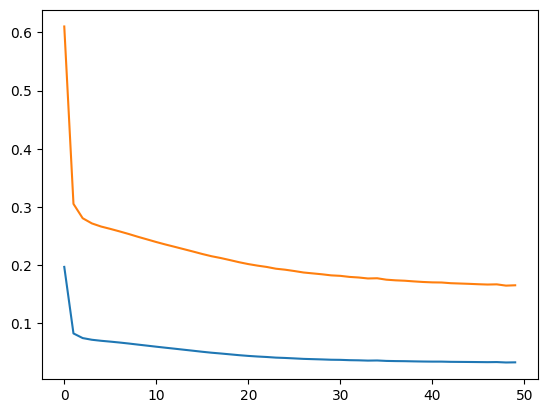

In [32]:
plt.plot(train_mse_loss)
plt.plot(train_bce_loss)

/home/shahbaa/miniconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


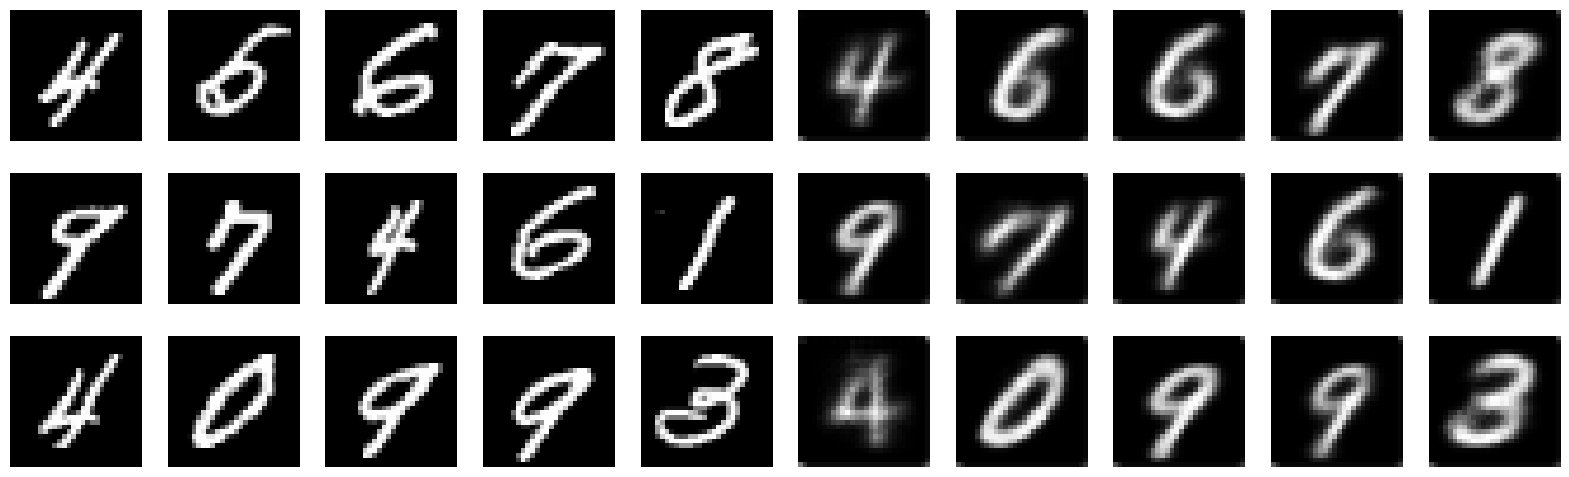

tensor(0.1656) tensor(0.0645)


In [34]:
embeddings = []
labels = []
BCE = []
MSE = []
for data in test_loader:
    images, y = data    
    images = images.to(device)
    outputs, embedding,_ = model(images)
    BCE.append(nn.BCELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
    MSE.append(nn.MSELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
    embeddings.append(embedding.detach().cpu())
    labels.append(y)

embeddings = torch.cat(embeddings)
labels = torch.cat(labels).numpy()
# k = gaussian_kde(embeddings.numpy().T)
# fig, ax = plt.subplots(1, 2, figsize=(20,10), subplot_kw={'projection': "mollweide"})
# scatter_mollweide_ax(embeddings,ax[0],c=labels)
# plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax[1])
# plt.show()

fig, ax = plt.subplots(3, 10, figsize=(20, 6))
for i in range(3):
    for j in range(10):
        if j < 5:  # First half for images
            ax[i, j].imshow(images[i*5+j, ...].squeeze().detach().cpu(), cmap='gray')
        else:  # Second half for outputs
            ax[i, j].imshow(outputs[i*5+j-5, ...].squeeze().detach().cpu(), cmap='gray')
        ax[i, j].axis('off')
plt.show()
BCE = torch.cat(BCE)
MSE = torch.cat(MSE)
print(BCE.mean(),BCE.std())

In [35]:
# test_bce_loss_array = np.array(BCE.numpy())
# np.save('./test_bce_loss_initial25_{}.npy'.format(kk), test_bce_loss_array)
# test_mse_loss_array = np.array(MSE.numpy())
# np.save('./test_mse_loss_initial25_{}.npy'.format(kk), test_mse_loss_array)
# test_embeddings = np.array(embeddings.numpy())
# np.save('./test_embeddings_initial25_{}.npy'.format(kk), test_embeddings)
# test_labels = np.array(labels)
# np.save('./test_labels_initial25_{}.npy'.format(kk), test_labels)

In [36]:
# embedding_dict={'initial':embedding_initial25,'ri1_s3wd':embedding_ri1_s3wd,'s3wd':embedding_S3WD,'sswd':embedding_SSWD}
# w_prior=[]
# for embd in embedding_dict.keys():
#     W=getOT(embedding_dict[embd],prior)
#     print(embd,'=',W)
#     w_prior.append(W)
    